# Cell tracking plugin 

Create a plugin to track cells 

1) Select image
2) Segment cells
3) Compute tracks
4) Display tracks interactively

In [1]:
from skimage.io import imread
import numpy as np
from magicgui import magicgui
import napari

## Load sample data

In [2]:
IMAGE = imread('https://zenodo.org/records/5206107/files/P31-crop.tif?download=1')
IMAGE_CROP = IMAGE[10:20,-100:,-100:]

## Define plugin functions

In [3]:
def segment_cells(images):
    from cellpose import models
    from skimage.util import img_as_float
    
    masks = []
    for image in images:
        model = models.CellposeModel(gpu=True)
        img = img_as_float(image)
        mask, __, __ = model.eval(image)
        masks.append(mask)
        
    return np.stack(masks)

def track_cells(label_image, features, config_file):
    import btrack
    
    objects = btrack.utils.segmentation_to_objects(label_image, properties=tuple(features))

    with btrack.BayesianTracker() as tracker:
        tracker.configure(config_file)
        tracker.append(objects)
        tracker.volume = ((0, label_image.shape[2]), (0, label_image.shape[1]))
        tracker.track_interactive(step_size=100)
        track_data = tracker.to_napari(ndim=2)
    
    return track_data

## Magicgui Implementation

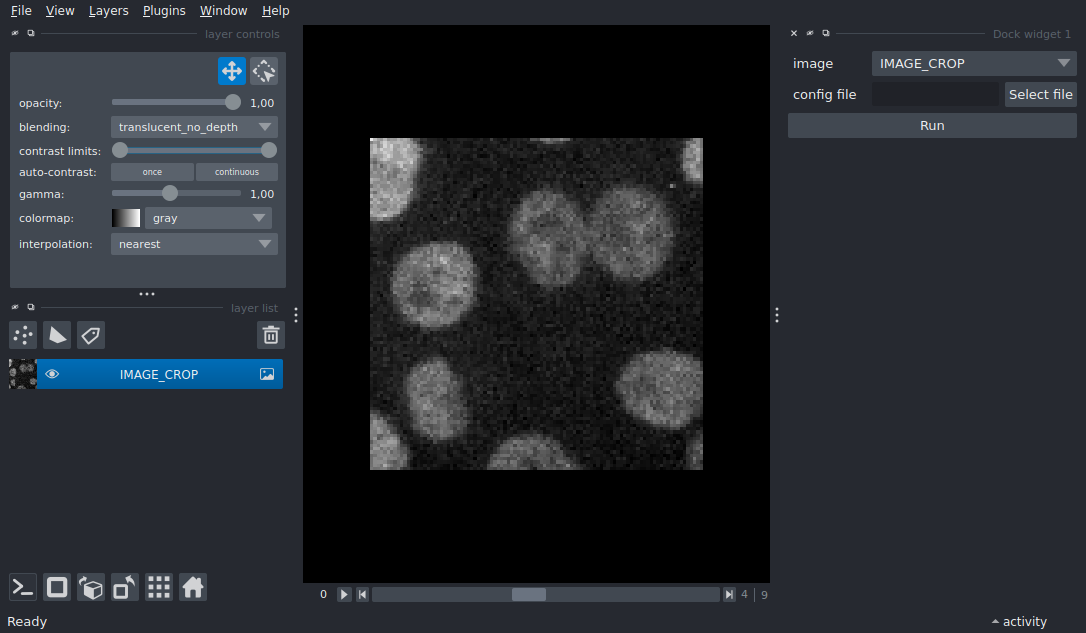

In [4]:
@magicgui(config_file={'label': 'config file',
                       'widget_type': 'FileEdit',
                       'mode': 'r',
                       'filter': '*.json'})
def cell_tracking(
    viewer: 'napari.viewer.Viewer',
    image: 'napari.layers.Image',
    config_file:  'pathlib.Path.home()'
) -> 'Union[napari.types.LabelsData, napari.layers.Tracks]':

    from napari.qt.threading import thread_worker

    features = ["area", "major_axis_length", "minor_axis_length", "orientation", "solidity"]
    
    def _add_tracking_data(return_value):
        mask, track_data = return_value
        data, properties, graph = track_data
        viewer.add_labels(mask)
        viewer.add_tracks(data, properties=properties, graph=graph, name='Tracks')

    @thread_worker(progress={"total":10})
    def _cell_tracking(image, mask, features, config_file):
        mask = segment_cells(image.data)
        track_data = track_cells(mask, features, config_file)

        yield mask, track_data

    worker = _cell_tracking(image,mask,features, config_file)
    worker.yielded.connect(_add_tracking_data)
    worker.start()

viewer = napari.view_image(IMAGE_CROP)
viewer.window.add_dock_widget(cell_tracking)
napari.utils.nbscreenshot(viewer)

## Magic Factory Implementation

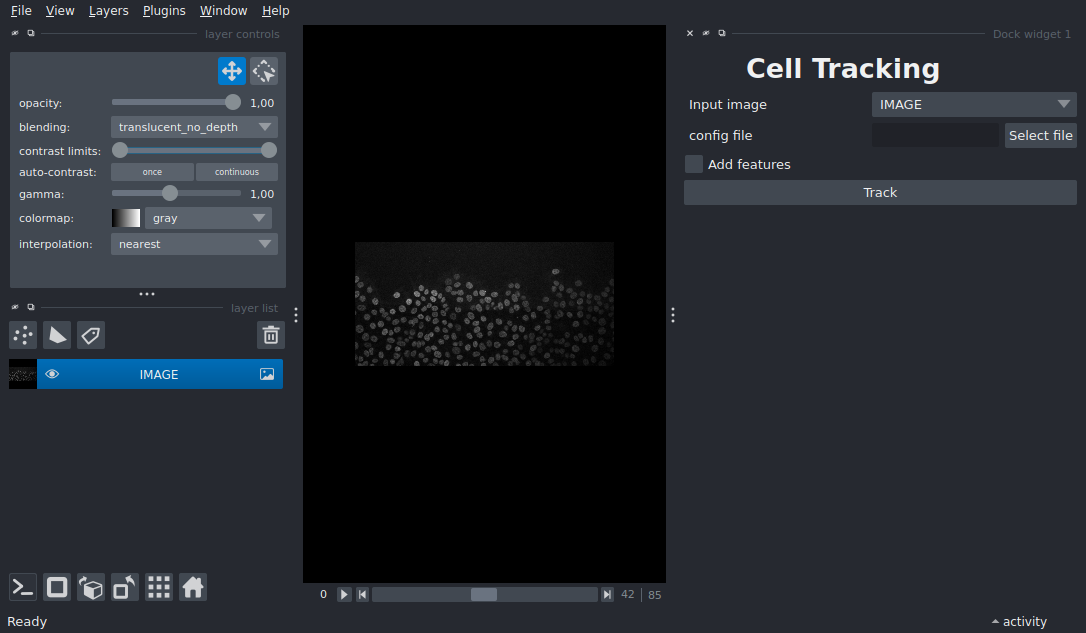



Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




[INFO][2025/05/11 06:54:43 ] Localizing objects from segmentation...
[INFO][2025/05/11 06:54:57 ] Objects are of type: <class 'dict'>
[INFO][2025/05/11 06:54:57 ] ...Found 22566 objects in 86 frames.
[INFO][2025/05/11 06:54:57 ] Loaded btrack: /home/daniel/anaconda3/envs/napari-env-2/lib/python3.11/site-packages/btrack/libs/libtracker.so
[INFO][2025/05/11 06:54:57 ] Starting BayesianTracker session
[INFO][2025/05/11 06:54:57 ] Loading configuration file: /home/daniel/Documents/TEACHING/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day1/napari-plugin/Group Exercises/Solutions/cell_config.json
[INFO][2025/05/11 06:54:57 ] Objects are of type: <class 'list'>
[WARNING][2025/05/11 06:54:57 ] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2025/05/11 06:54:57 ] Starting tracking... 
[INFO][2025/05/11 06:54:57 ] Update using: ['MOTION']
[INFO][2025/05/11 06:54:57 ] Tracking objects in frames 0 to 86 (of 86)...
[INFO][2025/05/11 06:54:59 ]  - Timing (Bayesian updates: 27.28

In [6]:
from magicgui import magic_factory

def on_init(widget):

    features = ['area', 'major_axis_length', 'minor_axis_length', 'orientation_', 'solidity', 'feature_header']

    for x in features:
        setattr(getattr(widget, x), 'visible', False)

    def toggle_feature_visbility(select_features: bool):
        if select_features:
            for x in features:
                setattr(getattr(widget, x), 'visible', True)
        else:
            for x in features:
                setattr(getattr(widget, x), 'visible', False)            

    widget.select_features.changed.connect(toggle_feature_visbility)
    
@magic_factory(
    widget_init=on_init, layout='vertical', call_button='Track',
    widget_header={'widget_type': 'Label',
                   'label':  f'<h1 text-align="left">Cell Tracking</h1>'},
    image={'label': 'Input image'},
    config_file={'label': 'config file',
                 'widget_type': 'FileEdit',
                 'mode': 'r',
                 'filter': '*.json'},
    
    select_features={'widget_type': 'CheckBox',
                     'label': 'Add features',
                     'value': False},
    feature_header={'widget_type': 'Label',
                    'label': f'<h3 text-align="left">Features</h3>'},
    area={'widget_type': 'CheckBox',
          'label': 'Area',
          'value': False},
    major_axis_length={'widget_type': 'CheckBox',
                       'label': 'Major axis length',
                       'value': False},
    minor_axis_length={'widget_type': 'CheckBox',
                       'label': 'Minor axis length',
                       'value': False},
    orientation_={'widget_type': 'CheckBox',
                 'label': 'Orientation',
                 'value': False},
    solidity={'widget_type': 'CheckBox',
              'label': 'Solidity',
              'value': False})
def cell_tracking(
    viewer: 'napari.viewer.Viewer',
    widget_header,
    image: 'napari.layers.Image',
    config_file,
    select_features,
    feature_header,
    area,
    major_axis_length,
    minor_axis_length,
    orientation_, 
    solidity
):
    from napari.qt.threading import thread_worker

    features = []
    if area:
        features.append('area')
    if major_axis_length:
        features.append('major_axis_length')
    if minor_axis_length:
        features.append('minor_axis_length')
    if orientation_:
        features.append('orientation')
    if solidity:
        features.append('solidity')
    
    def _add_tracking_data(return_value):
        mask, track_data = return_value
        data, properties, graph = track_data
        viewer.add_labels(mask)
        viewer.add_tracks(data, properties=properties, graph=graph, name='Tracks')

    @thread_worker(progress={"total":10})
    def _cell_tracking(image, features, config_file):
        mask = segment_cells(image.data)
        track_data = track_cells(mask, features, config_file)

        yield mask, track_data

    worker = _cell_tracking(image, features, config_file)
    worker.yielded.connect(_add_tracking_data)
    worker.start()

viewer = napari.view_image(IMAGE)
widget = cell_tracking()
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)